In [16]:
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
import numpy as np
import cv2
import torch
import os
from torch.utils.data import DataLoader
import json
import torchvision
import warnings
warnings.filterwarnings("ignore")

In [2]:

class CustomDataset(Dataset):
  def __init__(self,annotationFile:str,root_dir:str):
    self.coco = COCO(annotationFile)
    self.root_images = root_dir
    self.x_train = self.coco.getImgIds()
  def readFile(self,annotationfile:str):
    with open(annotationfile,"r") as f:
      return json.load(f)

  def __len__(self):
    return len(self.x_train)

  def get_resized_annotations(self,image_dim:tuple,bbox:list,resize:tuple):
    """resize annotations
    Args:
        image_dim (tuple): image shape
        bbox (list): bbox coordinates [x,y,w,h]
        resize (tuple): resize dimension (x,y)

    Returns:
        list: [x,y,w,h]
    """
    width_ratio,height_ratio = [resize[idx]/image_dim[idx] for idx in range(len(resize))]
    return (bbox[0]*height_ratio,bbox[1]*width_ratio,bbox[2]*height_ratio,bbox[3]*width_ratio)

  def __getitem__(self,index):
    img_info = self.coco.loadImgs(self.x_train[index])[0]
    img_main = cv2.imread(os.path.join(self.root_images, img_info['file_name']))
    img = cv2.resize(img_main,(600,600))
    img = img/255  
    annIds = self.coco.getAnnIds(imgIds=img_info['id']) 
    anns = self.coco.loadAnns(annIds)
    num_objs = len(anns)
    boxes = torch.zeros([num_objs,4], dtype=torch.float32)
    labels = torch.zeros(num_objs, dtype=torch.int64)

    for i in range(num_objs):
        [x,y,w,h]=anns[i]["bbox"]
        [x,y,w,h] = self.get_resized_annotations(img_main.shape,[x,y,w,h],(600,600))
        boxes[i] = torch.tensor(list(map(int,(x,y,x+w,y+h))))
        labels[i] = torch.tensor([anns[i]["category_id"]])

    img = torch.as_tensor(img, dtype=torch.float32)
    img = img.permute(2,0,1)
    data = {}
    data["boxes"] =  boxes
    data["labels"] = labels
    return img, data
  def collate_fn(self,batch):
        return tuple(zip(*batch))

# CustomDataset(annotationFile="/content/aquarium_dataset/train_annotations.json",root_dir="/content/aquarium_dataset/train_resized")

**Downloading Dataset**

In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json



api_token = {"username":"aiyazqpiai","key":"594fbadac2db11a334e4582eede7b585"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d sharansmenon/aquarium-dataset

 99% 67.0M/68.0M [00:04<00:00, 24.0MB/s]
100% 68.0M/68.0M [00:04<00:00, 17.3MB/s]


In [5]:
from IPython.display import clear_output
!unzip aquarium-dataset.zip -d aquarium_dataset
clear_output()


In [6]:
!mv -v "/content/aquarium_dataset/Aquarium Combined" /content/aquarium_dataset/Aquarium_Combined  && mkdir aquarium_dataset/Aquarium_Combined/train/annotations && mv -v aquarium_dataset/Aquarium_Combined/train/*.json aquarium_dataset/Aquarium_Combined/train/annotations
clear_output()

In [18]:
annotationFile = "/content/aquarium_dataset/Aquarium_Combined/train/annotations/_annotations.coco.json"
train_images = "/content/aquarium_dataset/Aquarium_Combined/train/"
custom_train_data = CustomDataset(annotationFile=annotationFile,root_dir=train_images)
len(custom_train_data)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


448

In [19]:
with open(annotationFile,"r") as f:
  data = json.load(f)

classes = [ann["name"] for ann in data["categories"]]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [21]:
def collate_fn(batch):
  return tuple(zip(*batch))

# train_dataloader = DataLoader(dataset=custom_train_data,
#                               batch_size=8,
#                               shuffle=True,
#                               num_workers=4,
#                               collate_fn=collate_fn)
# train_dataloader = DataLoader(custom_train_data, 
#                               batch_size=4, 
#                               shuffle=False, 
#                               num_workers=4, 
#                               collate_fn=collate_fn)

train_loader = DataLoader(custom_train_data, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [88]:
# model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, len(classes))

# # lets load the faster rcnn model
# model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
# in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
# model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, len(classes))

In [89]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)
# optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-5)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)
device

device(type='cuda')

In [90]:
# custom training function 
from tqdm import tqdm_notebook as tqdm
import numpy as np

def train_epoch(dataloader,
                epochs:int,
                model,
                optimizer,
                device):
  def one_epoch_train(dataloader,
                      epoch:int,
                      model,
                      optimizer,
                      device):
    total_loss=[]
    total_loss_dict=[]
    one_epoch_bar = tqdm(total=len(dataloader),desc=f"epoch {epoch}",leave=True)
    for batch,(images,targets) in enumerate(dataloader):
      images = [image.to(device) for image in images]
      targets = [{k:torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

      loss_dict = model(images,targets)
      losses = sum([loss for loss in loss_dict.values()])
      losses_dict = [{k:v.item()} for k,v in loss_dict.items()]

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

      total_loss.append(losses.item())
      total_loss_dict.append(losses_dict)

      one_epoch_bar.update(1)


    return total_loss,total_loss_dict
    
    
  epoch_progressbar = tqdm(total=epochs,desc=f"epochs : ")

  for epoch in range(1,epochs+1):
    epoch_progressbar.update(1)

    total_loss,total_loss_dict = one_epoch_train(dataloader,
                                                  epoch,
                                                  model,
                                                  optimizer,
                                                  device)
    print(f"epoch: {epoch} | loss: {np.mean(total_loss)}")



In [ ]:
# training phase

epochs = 10

train_epoch(dataloader=train_loader,
                epochs=epochs,
                model=model,
                optimizer=optimizer,
                device=device)

epochs :   0%|          | 0/10 [00:00<?, ?it/s]

epoch 1:   0%|          | 0/112 [00:00<?, ?it/s]

epoch: 0 | loss: 0.8808885599885669


epoch 2:   0%|          | 0/112 [00:00<?, ?it/s]

epoch: 1 | loss: 0.6236036199011973


epoch 3:   0%|          | 0/112 [00:00<?, ?it/s]

epoch: 2 | loss: 0.4855260069348982


epoch 4:   0%|          | 0/112 [00:00<?, ?it/s]

Testing Phase

In [85]:
from random import choice
test_image_dir = "/content/aquarium_dataset/Aquarium_Combined/test"
image_name = choice(os.listdir(test_image_dir))
resize = (600,600)
img_main = cv2.imread(os.path.join(test_image_dir, image_name))
img = torch.Tensor(cv2.resize(img_main,resize)/255).permute(2,0,1)
print(img)


tensor([[[0.0941, 0.1059, 0.1216,  ..., 0.1490, 0.1490, 0.1529],
         [0.1059, 0.1137, 0.1255,  ..., 0.1412, 0.1451, 0.1451],
         [0.1137, 0.1176, 0.1255,  ..., 0.1569, 0.1608, 0.1608],
         ...,
         [0.2588, 0.2745, 0.2863,  ..., 0.3137, 0.3255, 0.3333],
         [0.2745, 0.2824, 0.2863,  ..., 0.2980, 0.2902, 0.2824],
         [0.2824, 0.2784, 0.2784,  ..., 0.2902, 0.2941, 0.2980]],

        [[0.0392, 0.0510, 0.0627,  ..., 0.0941, 0.0941, 0.0980],
         [0.0510, 0.0588, 0.0706,  ..., 0.0863, 0.0902, 0.0902],
         [0.0588, 0.0627, 0.0706,  ..., 0.1020, 0.1059, 0.1059],
         ...,
         [0.2863, 0.3020, 0.3137,  ..., 0.3255, 0.3373, 0.3451],
         [0.3020, 0.3098, 0.3137,  ..., 0.3098, 0.3020, 0.2941],
         [0.3098, 0.3059, 0.3059,  ..., 0.3020, 0.3059, 0.3059]],

        [[0.0157, 0.0275, 0.0431,  ..., 0.0471, 0.0471, 0.0510],
         [0.0275, 0.0353, 0.0431,  ..., 0.0392, 0.0431, 0.0431],
         [0.0353, 0.0431, 0.0471,  ..., 0.0549, 0.0588, 0.

In [86]:
# img, _ = test_dataset[5]
# print(img)
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

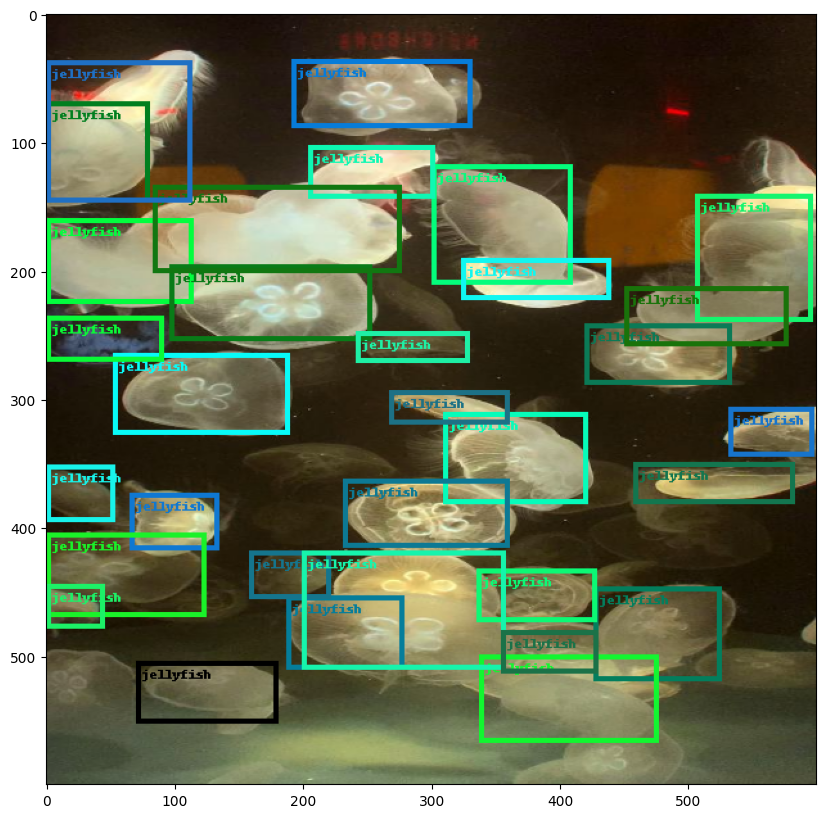

In [87]:
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.5],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.5].tolist()], width=4
).permute(1, 2, 0))